<a href="https://colab.research.google.com/github/konstanzer/drug-discovery/blob/master/drug-discovery-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug discovery using ChEMBL

ChEMBL or ChEMBLdb is a manually curated chemical database of bioactive molecules with drug-like properties. It is maintained by the European Bioinformatics Institute (EBI), of the European Molecular Biology Laboratory (EMBL), based at the Wellcome Trust Genome Campus, Hinxton, UK. 

#### Table of contents
1.   [Acquire & preprocess molecular data](#acquire)
2.   [Decision tree to predict IC50](#tree)
3.   [TensorFlow](#tensorflow)

## Install dependencies

In [ ]:
%%bash
pip install insilico==0.1.1
pip install chembl_webresource_client
pip install padelpy
pip install rdkit-pypi

In [2]:
from insilico import target_search, process_target_data

<a name='acquire'></a>
## Acquire & preprocess molecular data

In [3]:
target_search('knowlesi') #search chembl database

,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,Plasmodium knowlesi,Plasmodium knowlesi,17.0,False,CHEMBL613011,[],ORGANISM,5850


In [4]:
target_id = 'CHEMBL613011' #molecule id for P. knowlesi

In [5]:
df = process_target_data(target_id) #optional 'fp' param to specify fingerprinter

Query returned 12 molecules for CHEMBL613011
Computing fingerprints (takes several minutes if molecule count 1000+)...
Success!


In [6]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL1951761,CCCCCCCCCCCCC[C@H](O)C[C@H](O)[C@H](C)N,10500.0,inactive,301.515,4.14660,3.0,3.0,4.97881,CHEMBL1951761,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1951763,CCCCCCCCCCCCC[C@H](O)C[C@@H](O)[C@H](C)N,20300.0,inactive,301.515,4.14660,3.0,3.0,4.69250,CHEMBL1951763,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL1951762,CCCCCCCCCCCCC[C@@H](O)C[C@H](O)[C@H](C)N,17600.0,inactive,301.515,4.14660,3.0,3.0,4.75449,CHEMBL1951762,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL1951765,CCCCCCCCCCCCC[C@H](O)C[C@H](O)[C@H](C)NC,1700.0,intermediate,315.542,4.40730,3.0,3.0,5.76955,CHEMBL1951765,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL2035992,CCCCCCCCCCCCC[C@H](O)C[C@H](O)[C@H](C)N(C)C,6800.0,intermediate,329.569,4.74950,2.0,3.0,5.16749,CHEMBL2035992,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,CHEMBL2035993,CCCCCCCCCCCCC[C@H](O)C[C@H](O)[C@@H]1CCCN1,6300.0,intermediate,327.553,4.55140,3.0,3.0,5.20066,CHEMBL2035993,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,CHEMBL76,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,10.0,active,319.880,4.81060,1.0,3.0,8.00000,CHEMBL76,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,CHEMBL172,O[C@@H](c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)[C@...,40.0,active,378.316,4.44790,2.0,3.0,7.39794,CHEMBL172,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,CHEMBL4166227,Clc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,active,462.614,0.50020,0.0,3.0,7.09691,CHEMBL4166227,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,CHEMBL4174142,Fc1cccc2c1-c1ccccc1[I+]2.O=S(=O)([O-])C(F)(F)F,80.0,active,446.159,-0.01410,0.0,3.0,7.09691,CHEMBL4174142,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

SMILES: O=S(=O)([O-])C(F)(F)F.c1ccc2c(c1)[I+]c1ccccc1-2


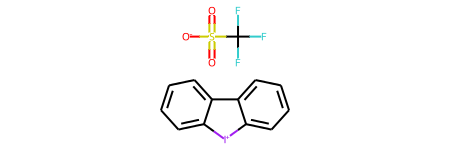

In [8]:
mol = df.Name[np.random.randint(len(df))]
SMILES = df.canonical_smiles[df.Name==mol].values[0]
print('SMILES:', SMILES)
Chem.MolFromSmiles(SMILES) 

<a name='tree'></a>
## Decision tree regressor to predict IC50

In [9]:
from sklearn.tree import export_text
from insilico import Model

In [10]:
mdl = Model(df, test_size=.2, var_threshold=.15) #declare class instance

We've dropped features with low variance (under 0.1) thereby reducing the fingerprint from 881 to 100-200 features. Optionally, try to maximize the cross-validation score in order to find the best hyperparameters.

(9, 93) (3, 93) (9,) (3,)
Cross-validation scores: [ 0.943 -0.509  0.906  0.323    nan]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:781: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


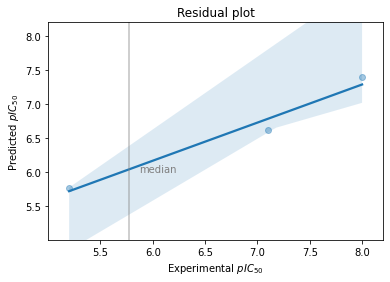

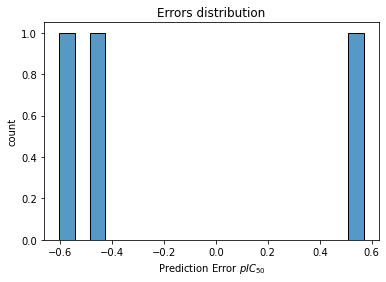

Plots saved in /usr/local/lib/python3.7/dist-packages/insilico/data


In [11]:
tree, metrics = mdl.decision_tree(ccp_alpha=.001)

In [12]:
metrics.index = ['train', 'test']
print(metrics)

       support  mean_absolute_error  r_squared
train        9              0.14517    0.94323
test         3              0.55134    0.77478


In [13]:
print(export_text(tree, max_depth=3)) #model saved in data folder

|--- feature_64 <= 0.50
|   |--- feature_40 <= 0.50
|   |   |--- feature_68 <= 0.50
|   |   |   |--- value: [4.81]
|   |   |--- feature_68 >  0.50
|   |   |   |--- value: [5.17]
|   |--- feature_40 >  0.50
|   |   |--- value: [5.77]
|--- feature_64 >  0.50
|   |--- feature_41 <= 0.50
|   |   |--- feature_15 <= 0.50
|   |   |   |--- value: [6.61]
|   |   |--- feature_15 >  0.50
|   |   |   |--- value: [6.96]
|   |--- feature_41 >  0.50
|   |   |--- value: [7.40]



<a name='tensorflow'></a>
## TensorFlow

[Basic regression TensorFlow tutorial](https://www.tensorflow.org/tutorials/keras/regression)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
X_train, X_test, y_train, y_test = mdl._prepare_dataframe(df)

(504, 83) (127, 83) (504,) (127,)


In [ ]:
normalizer = layers.Normalization(input_shape=[X_train.shape[1],])
normalizer.adapt(X_train) #does nothing to binary column

In [ ]:
linear_model = tf.keras.Sequential([normalizer,
                                    layers.Dense(units=1)])
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(X_train, y_train, epochs=50, verbose=0, validation_split = 0.2)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [pIC50]')
  plt.legend()
  plt.grid(True)

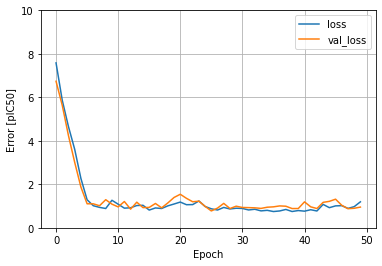

In [ ]:
plot_loss(history)


In [ ]:
test_results= {}
test_results['linear_model'] = linear_model.evaluate(
    X_test, y_test, verbose=0)

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.predict(X_train[:5]) #untrained preds

array([[ 0.20269059],
       [-0.1701796 ],
       [-1.2453167 ],
       [-0.8424696 ],
       [ 0.15149534]], dtype=float32)

In [ ]:
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 83)               167       
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                5376      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,656
Trainable params: 7,489
Non-trainable params: 167
_________________________________________________________________


In [ ]:
history = dnn_model.fit(X_train, y_train, epochs=100,
                        verbose=0, validation_split=0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.455535,0.765467,95
96,0.466021,0.769091,96
97,0.451643,0.745540,97
98,0.457825,0.775990,98
99,0.467427,0.736510,99


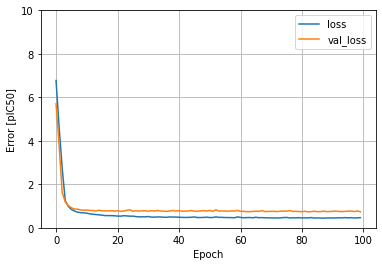

In [ ]:
plot_loss(history)


In [ ]:
test_results['neural_network'] = dnn_model.evaluate(X_test, y_test, verbose=0)
test_results['decision_tree'] = 0.62933

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [pIC50]']).T

,Mean absolute error [pIC50]
linear_model,0.905723
neural_network,0.632648
decision_tree,0.629330


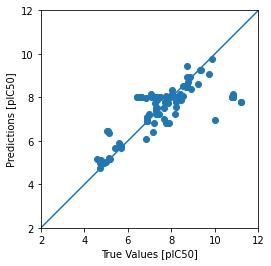

In [ ]:
test_predictions = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [pIC50]')
plt.ylabel('Predictions [pIC50]')
lims = [2, 12]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


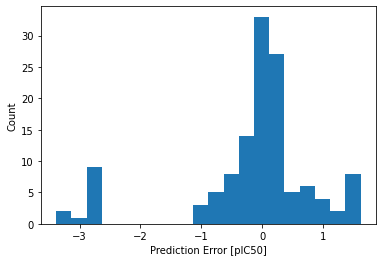

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins=20)
plt.xlabel('Prediction Error [pIC50]')
_ = plt.ylabel('Count')

In [ ]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

Mean squared error (MSE) (tf.losses.MeanMeanSquaredError) and mean absolute error (MAE) (tf.losses.MeanAbsoluteError) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.

Similarly, evaluation metrics used for regression differ from classification.

When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.

Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the Overfit and underfit tutorial for more help with this.
